In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
data_train = pd.read_csv('../dataset/DailyDelhiClimateTrain.csv')
data_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [3]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Temperature average')

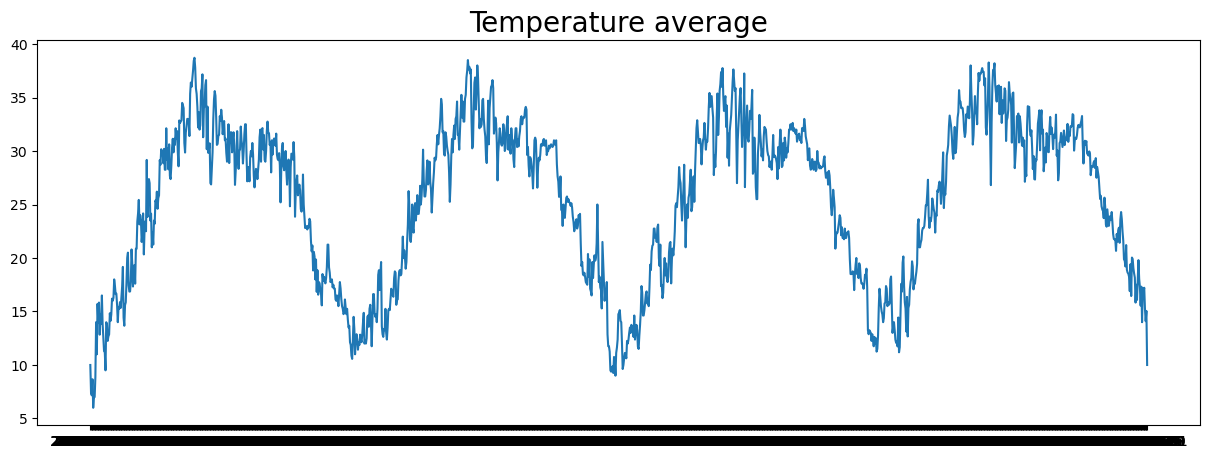

In [4]:
dates = data_train['date'].values
temp = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20)

In [5]:
# Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(temp, dates, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_set = windowed_dataset(
    X_train,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

test_set = windowed_dataset(
    X_test,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

model = tf.keras.models.Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
])

In [8]:
limit_mae = (data_train['meantemp'].max() - data_train['meantemp'].min()) * 10/100
limit_mae

3.2714285714285722

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae') < limit_mae:
      print('\nMAE < 10% Data Range')
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
optimizer = tf.keras.optimizers.SGD(1.000e-04, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

history = model.fit(train_set, epochs=100, validation_data=test_set, callbacks=[callbacks])

Epoch 1/100
     12/Unknown 12s 117ms/step - loss: 24.5436 - mae: 25.0436

c:\Users\ghifarullah19\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - loss: 24.5480 - mae: 25.0480 - val_loss: 28.1303 - val_mae: 28.6303
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 24.3285 - mae: 24.8285 - val_loss: 27.9660 - val_mae: 28.4660
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 24.2788 - mae: 24.7788 - val_loss: 27.7920 - val_mae: 28.2920
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 24.2417 - mae: 24.7417 - val_loss: 27.6239 - val_mae: 28.1239
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 24.1251 - mae: 24.6251 - val_loss: 27.4673 - val_mae: 27.9673
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 23.8604 - mae: 24.3604 - val_loss: 27.2947 - val_mae: 27.7947
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 23.4506 - mae: 23.9506 - val_loss: 27.1171 - val_mae: 27.6171
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 23.6543 - mae: 24.1543 - val_loss: 26.9477 - val_mae: 27.4477
Epoch 9/100
12/12 ━━━━━━━━━

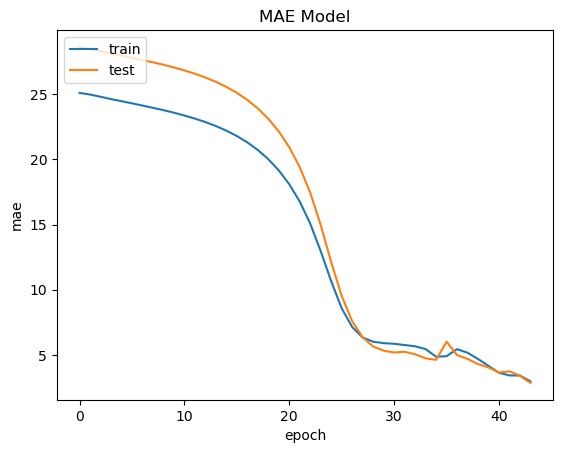

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

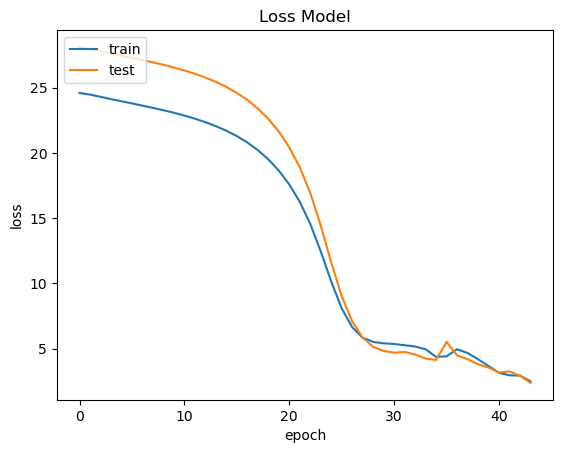

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()